In [1]:
import torch, torchvision

from pathlib import Path
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
import PIL.Image as Image
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
import shutil
from collections import defaultdict

from torch import nn, optim

import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models


In [2]:
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

class_indices = [0, 1, 2, 3, 4, 5, 6]

In [3]:
import torch
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# DenseNet-201

In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features, out_features, activation_func=nn.ReLU, dropout_rate=0.5):
        super(ResidualBlock, self).__init__()
        self.fc = nn.Linear(in_features, out_features)
        self.bn = nn.BatchNorm1d(out_features)
        self.activation = activation_func()
        self.dropout = nn.Dropout(dropout_rate)
        self.projection = nn.Linear(in_features, out_features) if in_features != out_features else nn.Identity()

    def forward(self, x):
        identity = self.projection(x)
        out = self.fc(x)
        out = self.bn(out)
        out = self.activation(out)
        out = self.dropout(out)
        out = out + identity
        return out

def create_model(n_classes, dropout_rates=[0.1, 0.2, 0.3, 0.4, 0.5]):
    model = models.densenet201(weights=models.DenseNet201_Weights.IMAGENET1K_V1)
    n_features = model.classifier.in_features

    model.classifier = nn.Sequential(
        ResidualBlock(n_features, 512, dropout_rate=dropout_rates[0]),
        ResidualBlock(512, 256, dropout_rate=dropout_rates[1]),
        ResidualBlock(256, 128, dropout_rate=dropout_rates[2]),
        ResidualBlock(128, 64, dropout_rate=dropout_rates[3]),
        ResidualBlock(64, 32, dropout_rate=dropout_rates[4]),
        nn.Linear(32, n_classes)  # Final layer for n_classes classification
    )

    return model.to(device)

In [5]:
Dense201 = create_model(len(class_names))

checkpoint_path = 'D:/Program Files (x86)/Softcom/DenseNet201_Custom2.pth'
checkpoint = torch.load(checkpoint_path)

Dense201.load_state_dict(torch.load(checkpoint_path, map_location=device))
Dense201.to(device)
Dense201.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

# ResNet-50

In [6]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features, out_features, activation_func=nn.ReLU, dropout_rate=0.5):
        super(ResidualBlock, self).__init__()
        self.fc = nn.Linear(in_features, out_features)
        self.bn = nn.BatchNorm1d(out_features)
        self.activation = activation_func()
        self.dropout = nn.Dropout(dropout_rate)
        self.projection = nn.Linear(in_features, out_features) if in_features != out_features else nn.Identity()

    def forward(self, x):
        identity = self.projection(x)
        out = self.fc(x)
        out = self.bn(out)
        out = self.activation(out)
        out = self.dropout(out)
        out = out + identity
        return out

def create_model(n_classes, dropout_rates=[0.1, 0.2, 0.3, 0.4, 0.5]):
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

    n_features = model.fc.in_features
    model.fc = nn.Sequential(
        ResidualBlock(n_features, 512, dropout_rate=dropout_rates[0]),
        ResidualBlock(512, 256, dropout_rate=dropout_rates[1]),
        ResidualBlock(256, 128, dropout_rate=dropout_rates[2]),
        ResidualBlock(128, 64, dropout_rate=dropout_rates[3]),
        ResidualBlock(64, 32, dropout_rate=dropout_rates[4]),
        nn.Linear(32, n_classes)
    )

    return model.to(device)

In [7]:
ResNet50 = create_model(len(class_names))

checkpoint_path = "D:/Program Files (x86)/Softcom/res50_Custom3.pth"
checkpoint = torch.load(checkpoint_path)

ResNet50.load_state_dict(torch.load(checkpoint_path, map_location=device))
ResNet50.to(device)
ResNet50.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# ResNet-101

In [8]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features, out_features, activation_func=nn.ReLU, dropout_rate=0.5):
        super(ResidualBlock, self).__init__()
        self.fc = nn.Linear(in_features, out_features)
        self.bn = nn.BatchNorm1d(out_features)
        self.activation = activation_func()
        self.dropout = nn.Dropout(dropout_rate)
        self.projection = nn.Linear(in_features, out_features) if in_features != out_features else nn.Identity()

    def forward(self, x):
        identity = self.projection(x)
        out = self.fc(x)
        out = self.bn(out)
        out = self.activation(out)
        out = self.dropout(out)
        out = out + identity
        return out

def create_model(n_classes, dropout_rates=[0.1, 0.2, 0.3, 0.4, 0.5]):
    model = models.resnet101(weights=models.ResNet101_Weights.IMAGENET1K_V1)

    n_features = model.fc.in_features
    model.fc = nn.Sequential(
        ResidualBlock(n_features, 512, dropout_rate=dropout_rates[0]),
        ResidualBlock(512, 256, dropout_rate=dropout_rates[1]),
        ResidualBlock(256, 128, dropout_rate=dropout_rates[2]),
        ResidualBlock(128, 64, dropout_rate=dropout_rates[3]),
        ResidualBlock(64, 32, dropout_rate=dropout_rates[4]),
        nn.Linear(32, n_classes)
    )

    return model.to(device)

In [9]:
ResNet101 = create_model(len(class_names))

checkpoint_path = 'D:/Program Files (x86)/Softcom/ResNet101_Custom3.pth'
checkpoint = torch.load(checkpoint_path)

ResNet101.load_state_dict(torch.load(checkpoint_path, map_location=device))
ResNet101.to(device)
ResNet101.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# ResNet-152

In [10]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features, out_features, activation_func=nn.ReLU, dropout_rate=0.5):
        super(ResidualBlock, self).__init__()
        self.fc = nn.Linear(in_features, out_features)
        self.bn = nn.BatchNorm1d(out_features)
        self.activation = activation_func()
        self.dropout = nn.Dropout(dropout_rate)
        self.projection = nn.Linear(in_features, out_features) if in_features != out_features else nn.Identity()

    def forward(self, x):
        identity = self.projection(x)
        out = self.fc(x)
        out = self.bn(out)
        out = self.activation(out)
        out = self.dropout(out)
        out = out + identity
        return out

def create_model(n_classes, dropout_rates=[0.1, 0.2, 0.3, 0.4, 0.5]):
    model = models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V1)

    n_features = model.fc.in_features
    model.fc = nn.Sequential(
        ResidualBlock(n_features, 512, dropout_rate=dropout_rates[0]),
        ResidualBlock(512, 256, dropout_rate=dropout_rates[1]),
        ResidualBlock(256, 128, dropout_rate=dropout_rates[2]),
        ResidualBlock(128, 64, dropout_rate=dropout_rates[3]),
        ResidualBlock(64, 32, dropout_rate=dropout_rates[4]),
        nn.Linear(32, n_classes)
    )

    return model.to(device)

In [11]:
ResNet152 = create_model(len(class_names))

checkpoint_path = 'D:/Program Files (x86)/Softcom/ResNet152_Custom3.pth'
checkpoint = torch.load(checkpoint_path)

ResNet152.load_state_dict(torch.load(checkpoint_path, map_location=device))
ResNet152.to(device)
ResNet152.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# VGG-19

In [12]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features, out_features, activation_func=nn.ReLU, dropout_rate=0.5):
        super(ResidualBlock, self).__init__()
        self.fc = nn.Linear(in_features, out_features)
        self.bn = nn.BatchNorm1d(out_features)
        self.activation = activation_func()
        self.dropout = nn.Dropout(dropout_rate)
        self.projection = nn.Linear(in_features, out_features) if in_features != out_features else nn.Identity()

    def forward(self, x):
        identity = self.projection(x)
        out = self.fc(x)
        out = self.bn(out)
        out = self.activation(out)
        out = self.dropout(out)
        out = out + identity
        return out

def create_model(n_classes, dropout_rates=[0.1, 0.2, 0.3, 0.4, 0.5]):
    model = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1)

    model.avgpool = nn.AdaptiveAvgPool2d((7, 7))

    in_features = 512 * 7 * 7

    model.classifier = nn.Sequential(
        nn.Flatten(),
        ResidualBlock(in_features, 512, dropout_rate=dropout_rates[0]),
        ResidualBlock(512, 256, dropout_rate=dropout_rates[1]),
        ResidualBlock(256, 128, dropout_rate=dropout_rates[2]),
        ResidualBlock(128, 64, dropout_rate=dropout_rates[3]),
        ResidualBlock(64, 32, dropout_rate=dropout_rates[4]),
        nn.Linear(32, n_classes)
    )

    return model.to(device)

In [13]:
VGG19 = create_model(len(class_names))
VGG19.classifier[-1]
IN_FEATURES = VGG19.classifier[-1].in_features

final_fc = nn.Linear(IN_FEATURES,len(class_names) )
VGG19.classifier[-1] = final_fc
print(VGG19.classifier)

checkpoint_path = 'D:/Program Files (x86)/Softcom/vgg19_Custom3.pth'
checkpoint = torch.load(checkpoint_path)

VGG19.load_state_dict(torch.load(checkpoint_path, map_location=device))
VGG19.to(device)
VGG19.eval()

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): ResidualBlock(
    (fc): Linear(in_features=25088, out_features=512, bias=True)
    (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
    (dropout): Dropout(p=0.1, inplace=False)
    (projection): Linear(in_features=25088, out_features=512, bias=True)
  )
  (2): ResidualBlock(
    (fc): Linear(in_features=512, out_features=256, bias=True)
    (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
    (dropout): Dropout(p=0.2, inplace=False)
    (projection): Linear(in_features=512, out_features=256, bias=True)
  )
  (3): ResidualBlock(
    (fc): Linear(in_features=256, out_features=128, bias=True)
    (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
    (dropout): Dropout(p=0.3, inplace=False)
    (projection): Linear(in_features=256, out_features=1

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

# VGG16

In [14]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features, out_features, activation_func=nn.ReLU, dropout_rate=0.5):
        super(ResidualBlock, self).__init__()
        self.fc = nn.Linear(in_features, out_features)
        self.bn = nn.BatchNorm1d(out_features)
        self.activation = activation_func()
        self.dropout = nn.Dropout(dropout_rate)
        self.projection = nn.Linear(in_features, out_features) if in_features != out_features else nn.Identity()

    def forward(self, x):
        identity = self.projection(x)
        out = self.fc(x)
        out = self.bn(out)
        out = self.activation(out)
        out = self.dropout(out)
        out = out + identity
        return out

def create_model(n_classes, dropout_rates=[0.1, 0.2, 0.3, 0.4, 0.5]):
    model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

    model.avgpool = nn.AdaptiveAvgPool2d((7, 7))

    in_features = 512 * 7 * 7

    model.classifier = nn.Sequential(
        nn.Flatten(),
        ResidualBlock(in_features, 512, dropout_rate=dropout_rates[0]),
        ResidualBlock(512, 256, dropout_rate=dropout_rates[1]),
        ResidualBlock(256, 128, dropout_rate=dropout_rates[2]),
        ResidualBlock(128, 64, dropout_rate=dropout_rates[3]),
        ResidualBlock(64, 32, dropout_rate=dropout_rates[4]),
        nn.Linear(32, n_classes)
    )

    return model.to(device)

In [15]:
VGG16 = create_model(len(class_names))
VGG16.classifier[-1]
IN_FEATURES = VGG16.classifier[-1].in_features

final_fc = nn.Linear(IN_FEATURES,len(class_names) )
VGG16.classifier[-1] = final_fc
print(VGG16.classifier)

checkpoint_path = 'D:/Program Files (x86)/Softcom/vgg16_Custom3.pth'
checkpoint = torch.load(checkpoint_path)

VGG16.load_state_dict(torch.load(checkpoint_path, map_location=device))
VGG16.to(device)
VGG16.eval()

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): ResidualBlock(
    (fc): Linear(in_features=25088, out_features=512, bias=True)
    (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
    (dropout): Dropout(p=0.1, inplace=False)
    (projection): Linear(in_features=25088, out_features=512, bias=True)
  )
  (2): ResidualBlock(
    (fc): Linear(in_features=512, out_features=256, bias=True)
    (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
    (dropout): Dropout(p=0.2, inplace=False)
    (projection): Linear(in_features=512, out_features=256, bias=True)
  )
  (3): ResidualBlock(
    (fc): Linear(in_features=256, out_features=128, bias=True)
    (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
    (dropout): Dropout(p=0.3, inplace=False)
    (projection): Linear(in_features=256, out_features=1

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# GoogleNet

In [16]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features, out_features, activation_func=nn.ReLU, dropout_rate=0.5):
        super(ResidualBlock, self).__init__()
        self.fc = nn.Linear(in_features, out_features)
        self.bn = nn.BatchNorm1d(out_features)
        self.activation = activation_func()
        self.dropout = nn.Dropout(dropout_rate)
        self.projection = nn.Linear(in_features, out_features) if in_features != out_features else nn.Identity()

    def forward(self, x):
        identity = self.projection(x)
        out = self.fc(x)
        out = self.bn(out)
        out = self.activation(out)
        out = self.dropout(out)
        out += identity
        return out

def create_model(n_classes, dropout_rates=[0.1, 0.2, 0.3, 0.4, 0.5], device='cpu'):
    model = models.googlenet(weights=models.GoogLeNet_Weights.IMAGENET1K_V1)

    model.aux_logits = False
    model.aux1 = None
    model.aux2 = None

    in_features = 1024

    model.fc = nn.Sequential(
        nn.Flatten(),
        ResidualBlock(in_features, 512, dropout_rate=dropout_rates[0]),
        ResidualBlock(512, 256, dropout_rate=dropout_rates[1]),
        ResidualBlock(256, 128, dropout_rate=dropout_rates[2]),
        ResidualBlock(128, 64, dropout_rate=dropout_rates[3]),
        ResidualBlock(64, 32, dropout_rate=dropout_rates[4]),
        nn.Linear(32, n_classes)
    )

    return model.to(device)

In [17]:
GoogleNet = create_model(len(class_names))

checkpoint_path = "D:/Program Files (x86)/Softcom/GOOGLENET.pth"
checkpoint = torch.load(checkpoint_path)

GoogleNet.load_state_dict(torch.load(checkpoint_path, map_location=device))
GoogleNet.to(device)
GoogleNet.eval()

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

# Soft-Voting ( **Test Data**(unseen))

In [20]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.autograd import Variable
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from PIL import Image
import numpy as np
import os


class Ensemble(nn.Module):
    def __init__(self, device):
        super(Ensemble, self).__init__()
        self.models = nn.ModuleList(models).to(device)  # Move all models to the specified device
        for model in self.models:
            model.eval()  # Set all models to evaluation mode

    def forward(self, x):
        output = torch.zeros([x.size(0), num_classes]).to(device)
        for model in self.models:
            output += model(x)
        output /= len(self.models)  # Average the output
        return output

models = [Dense201,ResNet50,ResNet101,ResNet152,VGG19,VGG16,GoogleNet]
num_classes = len(class_names)
ensemble_model = Ensemble(device)
ensemble_model.to(device)

Ensemble(
  (models): ModuleList(
    (0): DenseNet(
      (features): Sequential(
        (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu0): ReLU(inplace=True)
        (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (denseblock1): _DenseBlock(
          (denselayer1): _DenseLayer(
            (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu1): ReLU(inplace=True)
            (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu2): ReLU(inplace=True)
            (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          )
          (denselayer2): _DenseLayer(
       

In [21]:
import torch, torchvision

from pathlib import Path
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
import PIL.Image as Image
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
import shutil
from collections import defaultdict

from torch import nn, optim

import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models

In [22]:
test_folders = sorted(glob('D:/Program Files (x86)/Softcom/Test_Spects/*'))
len(test_folders)

7

In [23]:
def load_image(img_path, resize=True):
  img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

  if resize:
    img = cv2.resize(img, (224, 224), interpolation = cv2.INTER_AREA)

  return img

def show_image(img_path):
  img = load_image(img_path)
  plt.imshow(img)
  plt.axis('off')

def show_sign_grid(image_paths):
  images = [load_image(img) for img in image_paths]
  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow=11)
  plt.figure(figsize=(24, 12))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

C:\Users\tanve\AppData\Local\Temp\ipykernel_38004\2684945866.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:248.)
  images = torch.as_tensor(images)


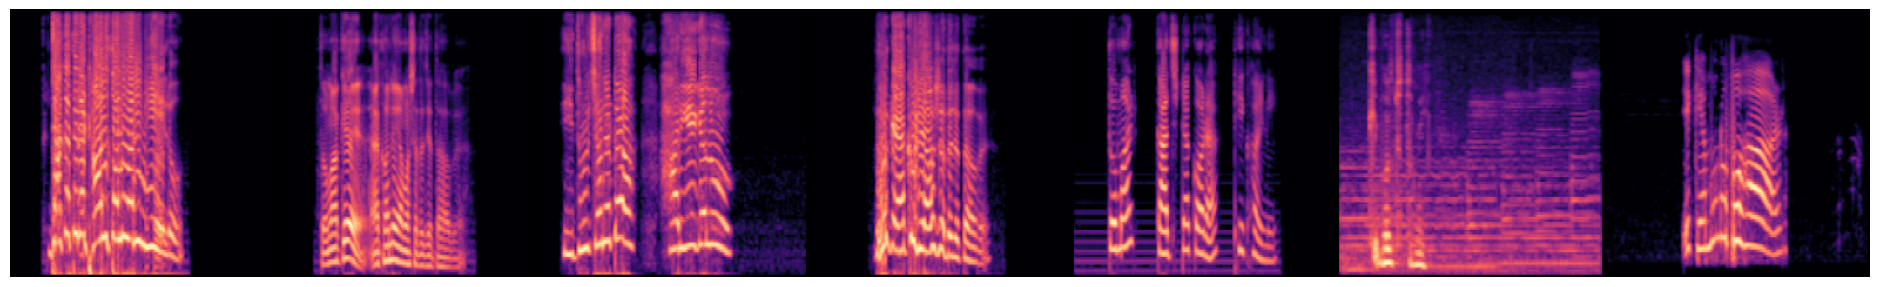

In [24]:
sample_images = [np.random.choice(glob(f'{tf}/*png')) for tf in test_folders]
show_sign_grid(sample_images)

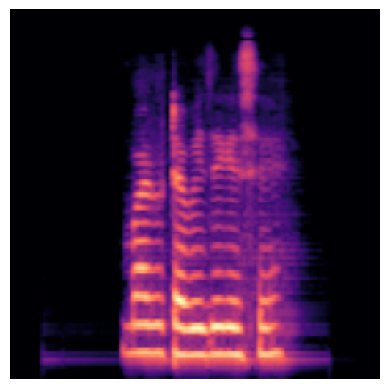

In [25]:
img_path = glob(f'{test_folders[4]}/*png')[1]

show_image(img_path)

In [26]:
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

class_indices = [0, 1, 2, 3, 4, 5, 6]

In [27]:
import subprocess
from pathlib import Path

# It's safer to check if the directory exists and then remove it using Python's built-in functions
DATA_DIR = Path('test')
if DATA_DIR.exists() and DATA_DIR.is_dir():
    shutil.rmtree(DATA_DIR)

class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
DATASETS = ['test']

# Recreate the directory structure
for ds in DATASETS:
  for cls in class_names:
    (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True)

In [28]:
for i, cls_index in enumerate(class_indices):
  image_paths = np.array(glob(f'{test_folders[cls_index]}/*.png'))
  class_name = class_names[i]
  print(f'{class_name}: {len(image_paths)}')
  np.random.shuffle(image_paths)

  ds_split = np.split(
    image_paths,
    indices_or_sections=[int(1.0*len(image_paths))]
  )

  dataset_data = zip(DATASETS, ds_split)

  for ds, images in dataset_data:
    for img_path in images:
      shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/')

Angry: 151
Disgust: 120
Fear: 100
Happy: 151
Neutral: 135
Sad: 151
Surprise: 131


In [29]:
#224*224
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transforms = {'test': T.Compose([
  T.Resize(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}

In [30]:
image_datasets = {
  d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}

data_loaders = {
  d: DataLoader(image_datasets[d], batch_size=5, shuffle=True, num_workers=2)
  for d in DATASETS
}

In [31]:
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['test'].classes

dataset_sizes

{'test': 939}

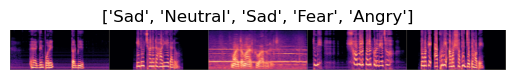

In [32]:
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([mean_nums])
  std = np.array([std_nums])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.axis('off')

inputs, classes = next(iter(data_loaders['test']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [33]:
def show_predictions(model, class_names, n_images=6):
  model = model.eval()
  images_handeled = 0
  plt.figure(figsize=(20,10))

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(data_loaders['test']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.shape[0]):
        images_handeled += 1
        ax = plt.subplot(2, n_images//2, images_handeled)
        ax.set_title(f'predicted: {class_names[preds[j]]}\n'  f'true: {class_names[labels[j]]}')
        imshow(inputs.cpu().data[j])
        ax.axis('off')

        if images_handeled == n_images:
          return

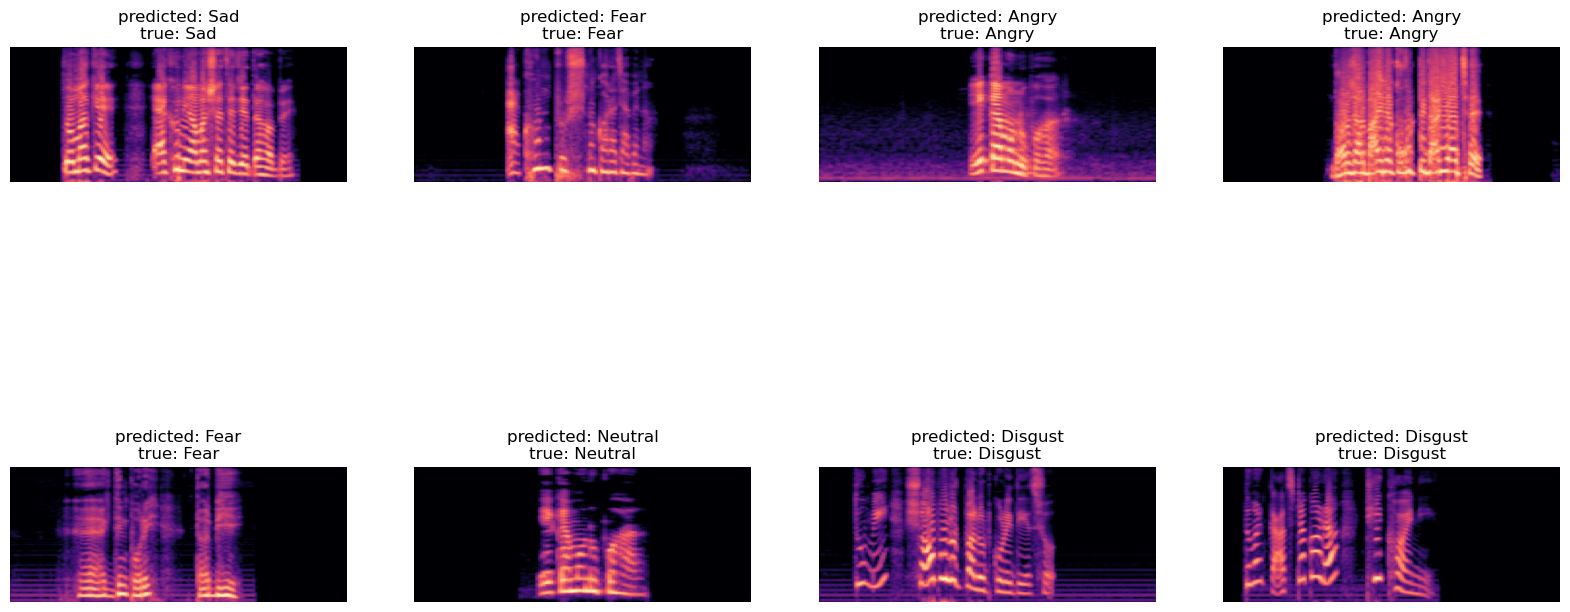

In [34]:
show_predictions(ensemble_model, class_names, n_images=8)

In [35]:
def get_predictions(model, data_loader):
  model = model.eval()
  predictions = []
  real_values = []
  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      predictions.extend(preds.cpu().numpy())
      real_values.extend(labels.cpu().numpy())
  predictions = torch.as_tensor(predictions).cpu()
  real_values = torch.as_tensor(real_values).cpu()
  return predictions, real_values

In [36]:
y_pred, y_test = get_predictions(ensemble_model, data_loaders['test'])

In [37]:
#224*224
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

       Angry       0.94      0.92      0.93       151
     Disgust       0.94      0.90      0.92       120
        Fear       0.99      0.98      0.98       100
       Happy       0.95      0.91      0.93       151
     Neutral       0.93      0.99      0.96       135
         Sad       0.95      0.98      0.96       151
    Surprise       0.93      0.94      0.94       131

    accuracy                           0.95       939
   macro avg       0.95      0.95      0.95       939
weighted avg       0.95      0.95      0.95       939



In [38]:
def show_confusion_matrix(confusion_matrix, class_names):

  cm = confusion_matrix.copy()

  cell_counts = cm.flatten()

  cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]

  row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]

  cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
  cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])

  df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)

  hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Sign')
  plt.xlabel('Predicted Sign');

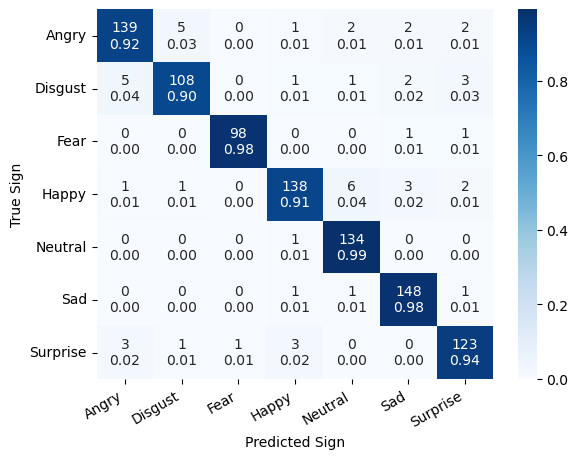

In [39]:
#64*64
cm = confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm, class_names)

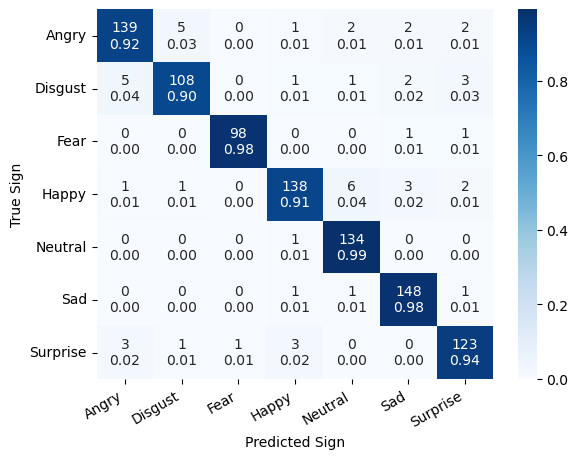

In [40]:
#224*224
cm = confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm, class_names)

# HARD-VOTING (**Test Data**(unseen))

In [41]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.autograd import Variable
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from PIL import Image
import numpy as np
import os
from collections import Counter

class Ensemble(nn.Module):
    def __init__(self, device):
        super(Ensemble, self).__init__()
        self.models = nn.ModuleList(models).to(device)  # Ensure models are on the correct device
        for model in self.models:
            model.eval() 

    def forward(self, x):
        votes = []
        for model in self.models:
            outputs = model(x)
            _, preds = torch.max(outputs, dim=1)
            votes.append(preds.unsqueeze(0))

        votes = torch.cat(votes, dim=0)
        final_preds, _ = torch.mode(votes, dim=0)
        return final_preds


models = [Dense201,ResNet50,ResNet101,ResNet152,VGG19,VGG16,GoogleNet]
num_classes = len(class_names)
ensemble_model = Ensemble(device)
ensemble_model.to(device)


Ensemble(
  (models): ModuleList(
    (0): DenseNet(
      (features): Sequential(
        (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu0): ReLU(inplace=True)
        (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (denseblock1): _DenseBlock(
          (denselayer1): _DenseLayer(
            (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu1): ReLU(inplace=True)
            (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu2): ReLU(inplace=True)
            (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          )
          (denselayer2): _DenseLayer(
       

In [42]:
import torch, torchvision

from pathlib import Path
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
import PIL.Image as Image
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
import shutil
from collections import defaultdict

from torch import nn, optim

import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models

In [43]:
test_folders = sorted(glob('D:/Program Files (x86)/Softcom/Test_Spects/*'))
len(test_folders)

7

In [44]:
def load_image(img_path, resize=True):
  img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

  if resize:
    img = cv2.resize(img, (224, 224), interpolation = cv2.INTER_AREA)

  return img

def show_image(img_path):
  img = load_image(img_path)
  plt.imshow(img)
  plt.axis('off')

def show_sign_grid(image_paths):
  images = [load_image(img) for img in image_paths]
  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow=11)
  plt.figure(figsize=(24, 12))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

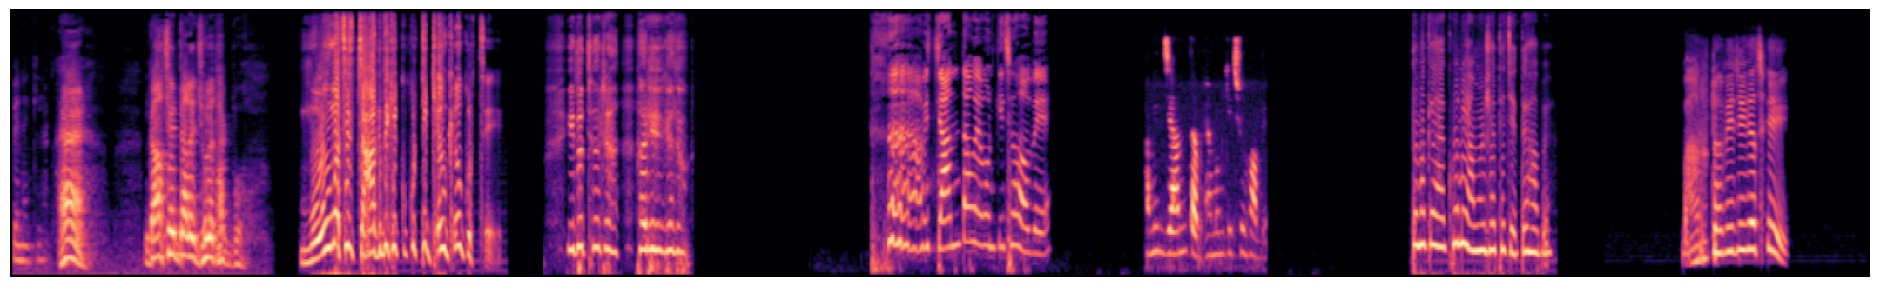

In [45]:
sample_images = [np.random.choice(glob(f'{tf}/*png')) for tf in test_folders]
show_sign_grid(sample_images)

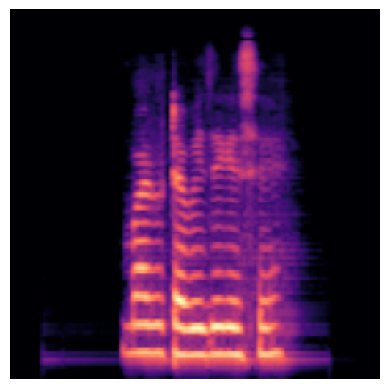

In [46]:
img_path = glob(f'{test_folders[4]}/*png')[1]

show_image(img_path)

In [47]:
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

class_indices = [0, 1, 2, 3, 4, 5, 6]

In [48]:
import subprocess
from pathlib import Path

# It's safer to check if the directory exists and then remove it using Python's built-in functions
DATA_DIR = Path('test')
if DATA_DIR.exists() and DATA_DIR.is_dir():
    shutil.rmtree(DATA_DIR)

class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
DATASETS = ['test']

# Recreate the directory structure
for ds in DATASETS:
  for cls in class_names:
    (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True)

In [49]:
for i, cls_index in enumerate(class_indices):
  image_paths = np.array(glob(f'{test_folders[cls_index]}/*.png'))
  class_name = class_names[i]
  print(f'{class_name}: {len(image_paths)}')
  np.random.shuffle(image_paths)

  ds_split = np.split(
    image_paths,
    indices_or_sections=[int(1.0*len(image_paths))]
  )

  dataset_data = zip(DATASETS, ds_split)

  for ds, images in dataset_data:
    for img_path in images:
      shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/')

Angry: 151
Disgust: 120
Fear: 100
Happy: 151
Neutral: 135
Sad: 151
Surprise: 131


In [50]:
#224*224
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transforms = {'test': T.Compose([
  T.Resize(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}

In [51]:
image_datasets = {
  d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}

data_loaders = {
  d: DataLoader(image_datasets[d], batch_size=5, shuffle=True, num_workers=2)
  for d in DATASETS
}

In [52]:
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['test'].classes

dataset_sizes

{'test': 939}

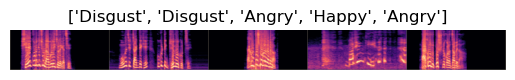

In [53]:
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([mean_nums])
  std = np.array([std_nums])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.axis('off')

inputs, classes = next(iter(data_loaders['test']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [54]:
import matplotlib.pyplot as plt

def show_predictions(model, class_names, n_images=6):
    model.eval()  # Set the model to evaluation mode
    images_handled = 0
    plt.figure(figsize=(20, 10))

    with torch.no_grad():
        for inputs, labels in data_loaders['test']:
            inputs, labels = inputs.to(device), labels.to(device)

            preds = model(inputs)

            for j in range(inputs.size(0)):
                images_handled += 1
                ax = plt.subplot(2, n_images // 2, images_handled)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j].item()]}\ntrue: {class_names[labels[j].item()]}')
                imshow(inputs.cpu().data[j])  # Ensure imshow is defined to display the input image

                if images_handled == n_images:
                    return

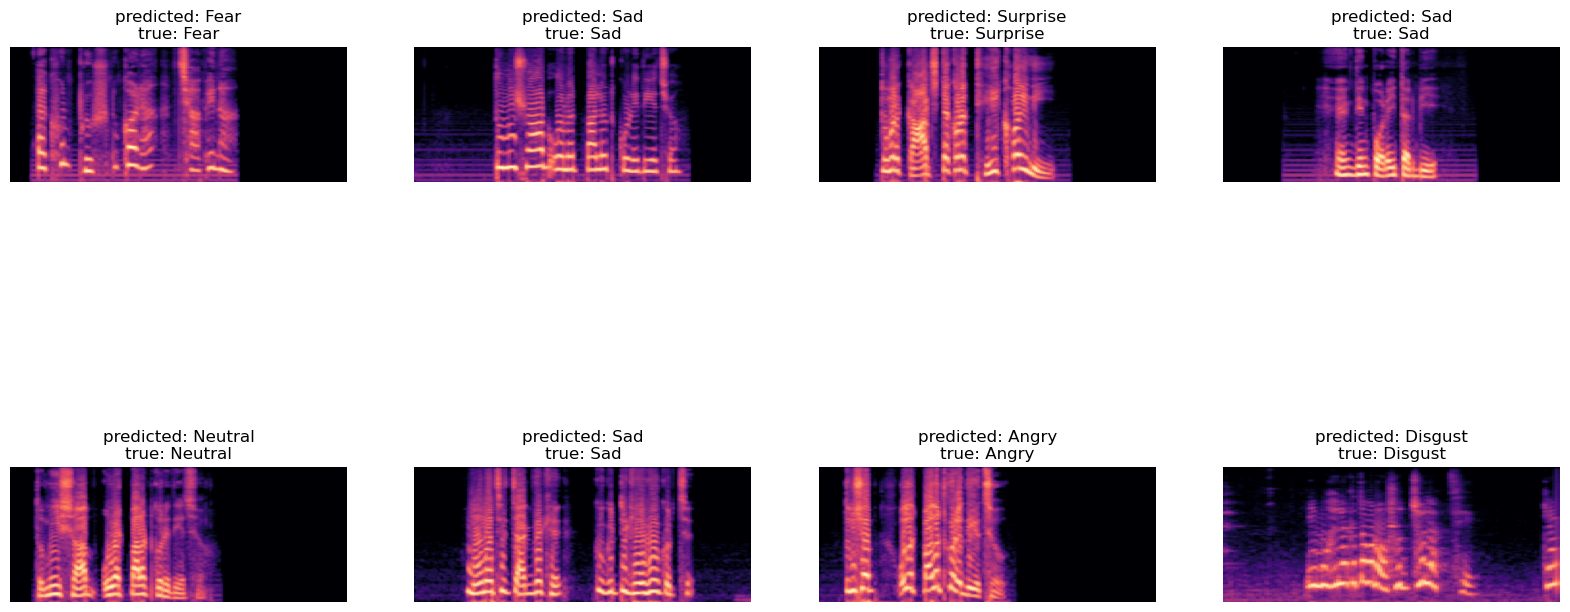

In [55]:
show_predictions(ensemble_model, class_names, n_images=8)

In [56]:
def get_predictions(model, data_loader):
    model.eval() 
    predictions = []
    real_values = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            preds = model(inputs)
            
            predictions.extend(preds.cpu().numpy()) 
            real_values.extend(labels.cpu().numpy())

    predictions = torch.tensor(predictions).cpu() 
    real_values = torch.tensor(real_values).cpu()
    return predictions, real_values


In [57]:
y_pred, y_test = get_predictions(ensemble_model, data_loaders['test'])

In [58]:
#224*224
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

       Angry       0.95      0.93      0.94       151
     Disgust       0.93      0.92      0.92       120
        Fear       0.99      0.97      0.98       100
       Happy       0.96      0.91      0.94       151
     Neutral       0.93      0.99      0.96       135
         Sad       0.94      0.97      0.96       151
    Surprise       0.93      0.95      0.94       131

    accuracy                           0.95       939
   macro avg       0.95      0.95      0.95       939
weighted avg       0.95      0.95      0.95       939



In [59]:
def show_confusion_matrix(confusion_matrix, class_names):

  cm = confusion_matrix.copy()

  cell_counts = cm.flatten()

  cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]

  row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]

  cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
  cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])

  df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)

  hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Sign')
  plt.xlabel('Predicted Sign');

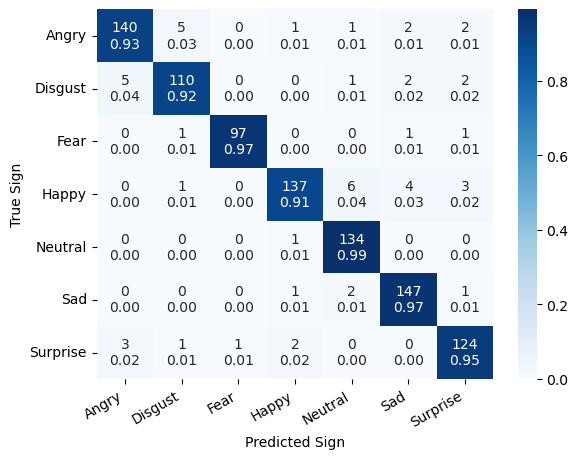

In [60]:
#64*64
cm = confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm, class_names)

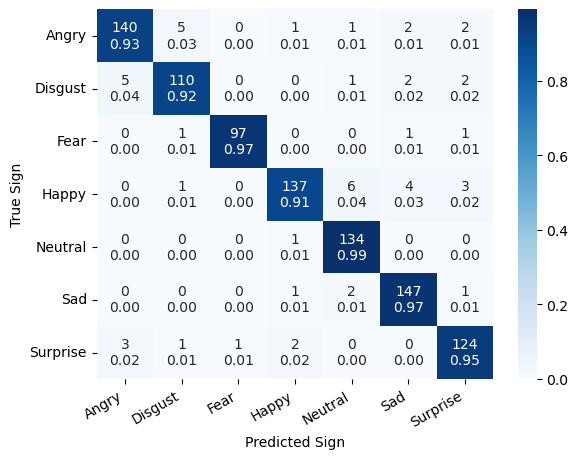

In [61]:
#224*224
cm = confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm, class_names)